# 任务一：Yale人脸数据集 - 数据预处理与特征工程

本notebook完成以下任务：
1. 读取并可视化Yale数据集
2. 图像尺寸归一化与灰度归一化
3. 提取全局特征与局部特征进行可视化分析
4. 为人脸识别与拒识系统准备数据

---

## 1. 导入必要的库

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from skimage.feature import hog, local_binary_pattern
from skimage import exposure
import warnings


d:\Anaconda\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
d:\Anaconda\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


## 2. 数据集读取与基本信息

In [5]:
# 定义数据路径
DATA_PATH = "./datasets/yale_data"

# 定义表情/状态类别
EXPRESSIONS = [
    'centerlight', 'glasses', 'happy', 'leftlight', 'noglasses',
    'normal', 'rightlight', 'sad', 'sleepy', 'surprised', 'wink'
]

def load_yale_dataset(data_path):
    """
    读取Yale人脸数据集
    返回：图像列表、标签列表、被试ID列表、表情类别列表
    """
    images = []
    labels = []  # 被试ID (1-15)
    expressions = []  # 表情/状态类别
    filenames = []
    
    # 获取所有文件
    files = sorted([f for f in os.listdir(data_path) if f.startswith('subject')])
    
    for filename in files:
        filepath = os.path.join(data_path, filename)
        
        try:
            # 解析文件名：subjectXX.expression
            parts = filename.split('.')
            subject_id = int(parts[0].replace('subject', ''))
            expression = parts[1] if len(parts) > 1 else 'unknown'
            
            # 读取图像（Yale数据集是GIF格式）
            img = Image.open(filepath)
            img_array = np.array(img)
            
            images.append(img_array)
            labels.append(subject_id)
            expressions.append(expression)
            filenames.append(filename)
            
        except Exception as e:
            print(f"读取文件 {filename} 时出错: {e}")
    
    return images, labels, expressions, filenames

# 加载数据
print("正在加载Yale数据集...")
images, labels, expressions, filenames = load_yale_dataset(DATA_PATH)
print(f"\n数据集加载完成！")
print(f"总图像数量: {len(images)}")
print(f"被试数量: {len(set(labels))}")
print(f"表情/状态类别数量: {len(set(expressions))}")
print(f"表情类别: {sorted(set(expressions))}")

正在加载Yale数据集...

数据集加载完成！
总图像数量: 165
被试数量: 15
表情/状态类别数量: 11
表情类别: ['centerlight', 'glasses', 'happy', 'leftlight', 'noglasses', 'normal', 'rightlight', 'sad', 'sleepy', 'surprised', 'wink']


In [6]:
# 查看图像基本信息
print("=" * 50)
print("图像基本信息统计")
print("=" * 50)

# 统计图像尺寸
shapes = [img.shape for img in images]
unique_shapes = list(set(shapes))

print(f"\n图像尺寸种类数: {len(unique_shapes)}")
print("\n各尺寸及其数量:")
for shape in sorted(unique_shapes):
    count = shapes.count(shape)
    print(f"  {shape}: {count} 张图像")

# 统计像素值范围
print(f"\n像素值范围:")
all_min = min([img.min() for img in images])
all_max = max([img.max() for img in images])
print(f"  最小值: {all_min}")
print(f"  最大值: {all_max}")

# 数据类型
print(f"\n数据类型: {images[0].dtype}")

图像基本信息统计

图像尺寸种类数: 1

各尺寸及其数量:
  (243, 320): 165 张图像

像素值范围:
  最小值: 0
  最大值: 255

数据类型: uint8


## 3. 数据集可视化

C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\2871279108.py:25: UserWarning: Glyph 34987 (\N{CJK UNIFIED IDEOGRAPH-88AB}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\2871279108.py:25: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAPH-8BD5}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\2871279108.py:25: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\2871279108.py:25: UserWarning: Glyph 25152 (\N{CJK UNIFIED IDEOGRAPH-6240}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\2871279108.py:25: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\2871279108.py:25: UserWarn

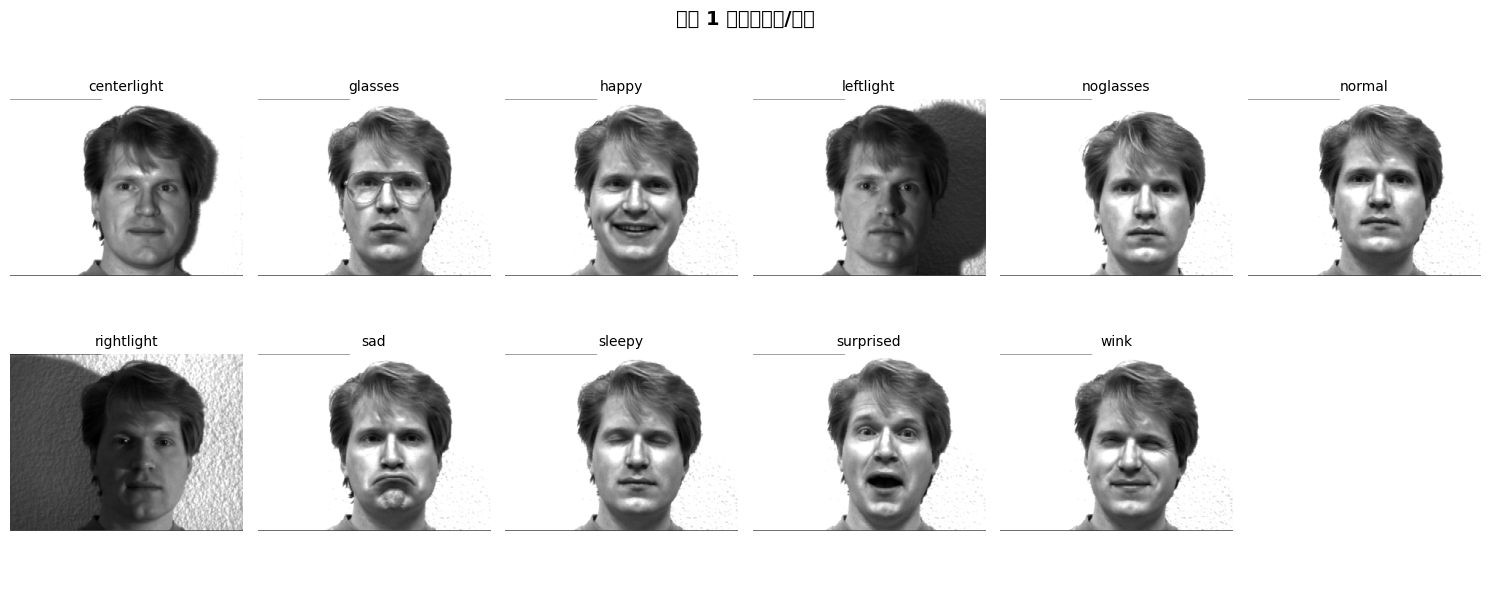

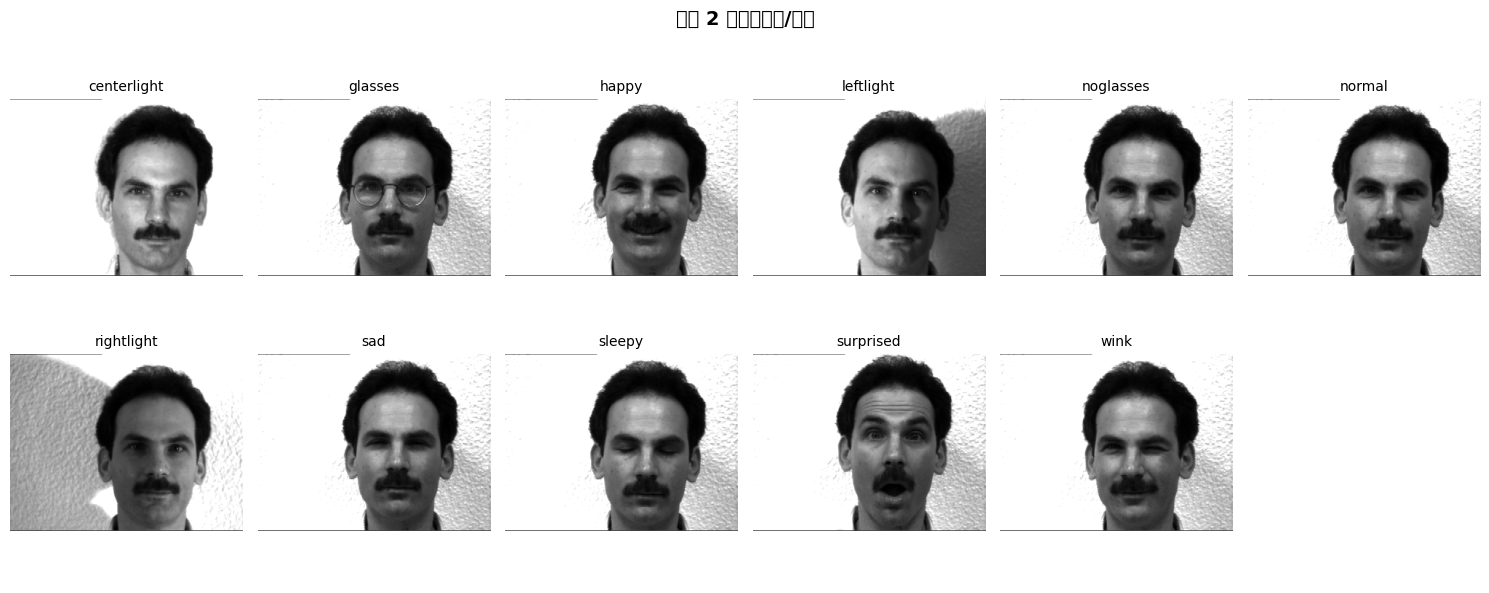

In [7]:
# 可视化每个被试的不同表情
def visualize_subject_expressions(images, labels, expressions, subject_id=1):
    """
    可视化某个被试的所有表情
    """
    subject_indices = [i for i, l in enumerate(labels) if l == subject_id]
    
    n_images = len(subject_indices)
    cols = min(6, n_images)
    rows = (n_images + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten() if n_images > 1 else [axes]
    
    for idx, (ax, img_idx) in enumerate(zip(axes, subject_indices)):
        ax.imshow(images[img_idx], cmap='gray')
        ax.set_title(f'{expressions[img_idx]}', fontsize=10)
        ax.axis('off')
    
    # 隐藏多余的子图
    for ax in axes[n_images:]:
        ax.axis('off')
    
    plt.suptitle(f'被试 {subject_id} 的所有表情/状态', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# 展示被试1的所有表情
visualize_subject_expressions(images, labels, expressions, subject_id=1)
visualize_subject_expressions(images, labels, expressions, subject_id=2)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\1295588205.py:24: UserWarning: Glyph 25152 (\N{CJK UNIFIED IDEOGRAPH-6240}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\1295588205.py:24: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\1295588205.py:24: UserWarning: Glyph 34987 (\N{CJK UNIFIED IDEOGRAPH-88AB}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\1295588205.py:24: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAPH-8BD5}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\1295588205.py:24: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\1295588205.py:24: UserWarn

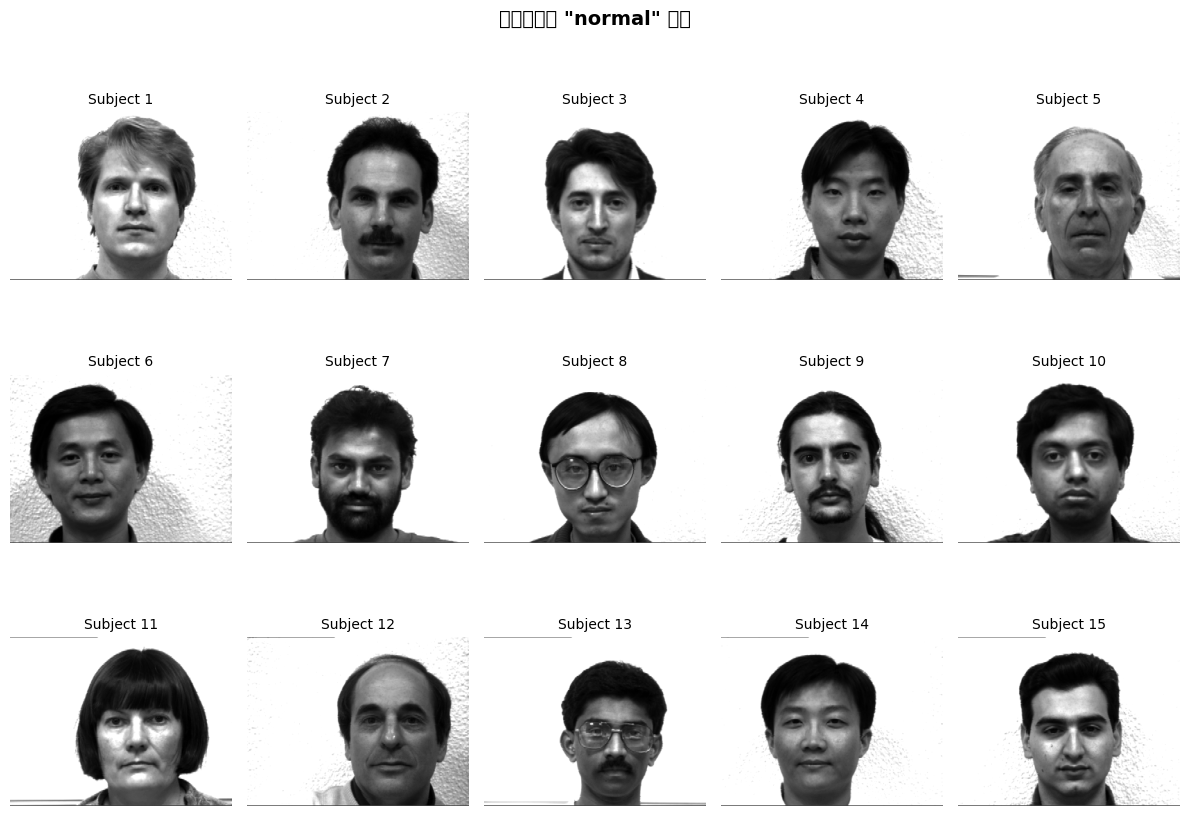

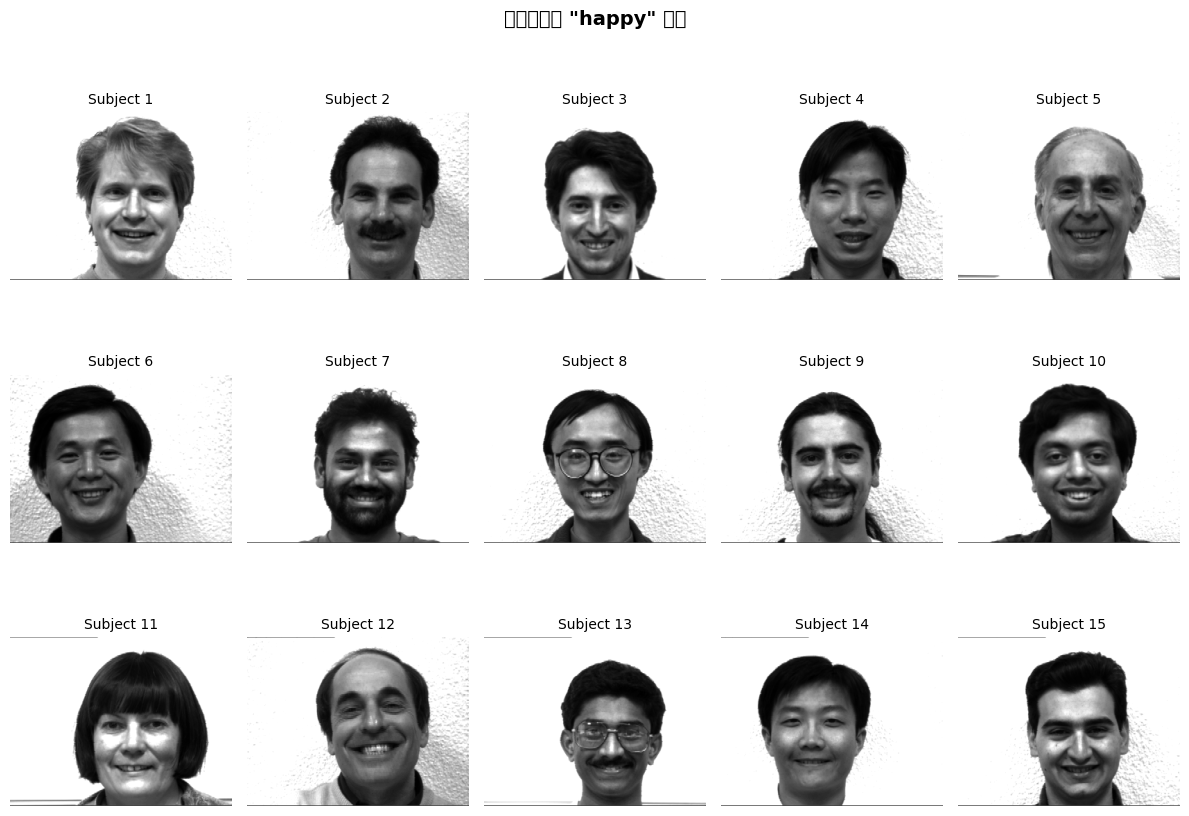

In [8]:
# 可视化不同被试的同一表情
def visualize_expression_across_subjects(images, labels, expressions, target_expression='normal'):
    """
    可视化所有被试的同一种表情
    """
    expr_indices = [i for i, e in enumerate(expressions) if e == target_expression]
    
    n_images = len(expr_indices)
    cols = min(5, n_images)
    rows = (n_images + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
    axes = axes.flatten() if n_images > 1 else [axes]
    
    for idx, (ax, img_idx) in enumerate(zip(axes, expr_indices)):
        ax.imshow(images[img_idx], cmap='gray')
        ax.set_title(f'Subject {labels[img_idx]}', fontsize=10)
        ax.axis('off')
    
    for ax in axes[n_images:]:
        ax.axis('off')
    
    plt.suptitle(f'所有被试的 "{target_expression}" 表情', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# 展示所有被试的normal表情
visualize_expression_across_subjects(images, labels, expressions, 'normal')
visualize_expression_across_subjects(images, labels, expressions, 'happy')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\2892911833.py:20: UserWarning: Glyph 34987 (\N{CJK UNIFIED IDEOGRAPH-88AB}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\2892911833.py:20: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAPH-8BD5}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\2892911833.py:20: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\2892911833.py:20: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\2892911833.py:20: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\2892911833.py:20: UserWarn

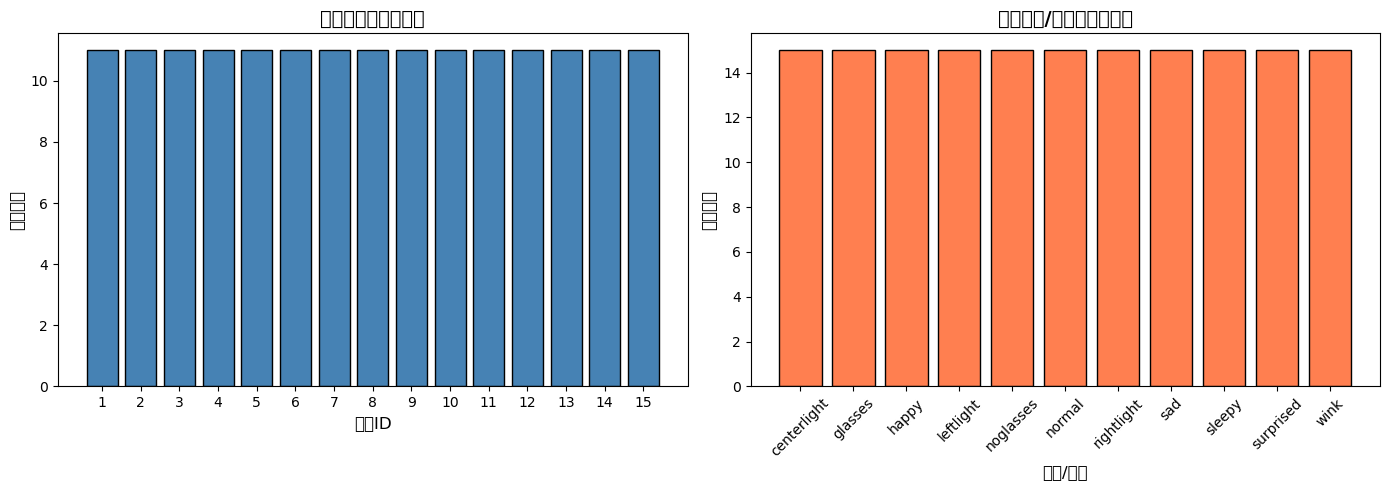

In [9]:
# 绘制数据集统计图
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 每个被试的图像数量
subject_counts = [labels.count(i) for i in range(1, 16)]
axes[0].bar(range(1, 16), subject_counts, color='steelblue', edgecolor='black')
axes[0].set_xlabel('被试ID', fontsize=12)
axes[0].set_ylabel('图像数量', fontsize=12)
axes[0].set_title('每个被试的图像数量', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(1, 16))

# 每种表情的图像数量
expr_counts = {e: expressions.count(e) for e in EXPRESSIONS}
axes[1].bar(expr_counts.keys(), expr_counts.values(), color='coral', edgecolor='black')
axes[1].set_xlabel('表情/状态', fontsize=12)
axes[1].set_ylabel('图像数量', fontsize=12)
axes[1].set_title('每种表情/状态的图像数量', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 4. 图像预处理

### 4.1 图像尺寸归一化

In [14]:
# 定义目标尺寸
TARGET_SIZE = (100, 100)  # 宽度 x 高度

def resize_images(images, target_size=TARGET_SIZE):
    """
    将所有图像调整为统一尺寸
    使用双三次插值保证图像质量
    """
    resized_images = []
    
    for img in images:
        # 使用OpenCV进行尺寸调整
        resized = cv2.resize(img, target_size, interpolation=cv2.INTER_CUBIC)
        resized_images.append(resized)
    
    return np.array(resized_images)

# 调整图像尺寸
print(f"正在将图像调整为 {TARGET_SIZE} 尺寸...")
images_resized = resize_images(images, TARGET_SIZE)
print(f"完成！输出形状: {images_resized.shape}")

正在将图像调整为 (100, 100) 尺寸...
完成！输出形状: (165, 100, 100)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\1633652495.py:21: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\1633652495.py:21: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\1633652495.py:21: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\1633652495.py:21: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\1633652495.py:21: UserWarning: Glyph 24402 (\N{CJK UNIFIED IDEOGRAPH-5F52}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\1633652495.py:21: UserWarn

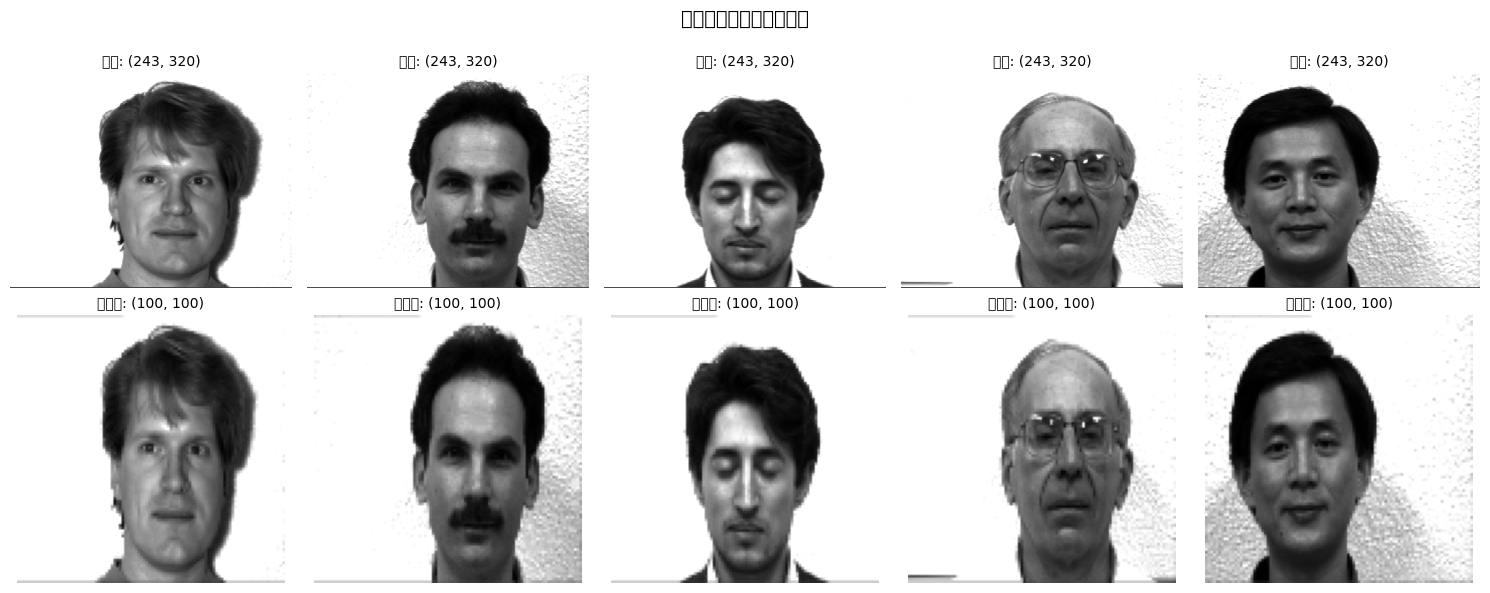

In [15]:
# 可视化尺寸调整前后的对比
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

sample_indices = [0, 15, 30, 45, 60]  # 选择一些样本

for i, idx in enumerate(sample_indices):
    # 原始图像
    axes[0, i].imshow(images[idx], cmap='gray')
    axes[0, i].set_title(f'原始: {images[idx].shape}', fontsize=10)
    axes[0, i].axis('off')
    
    # 调整后的图像
    axes[1, i].imshow(images_resized[idx], cmap='gray')
    axes[1, i].set_title(f'调整后: {images_resized[idx].shape}', fontsize=10)
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('原始图像', fontsize=12, rotation=0, ha='right', va='center')
axes[1, 0].set_ylabel('归一化后', fontsize=12, rotation=0, ha='right', va='center')

plt.suptitle('图像尺寸归一化前后对比', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 4.2 灰度归一化

In [16]:
def normalize_grayscale(images, method='minmax'):
    """
    灰度归一化
    method: 'minmax' - 最小最大归一化 [0, 1]
            'zscore' - Z-score标准化
            'histogram' - 直方图均衡化
    """
    normalized_images = []
    
    for img in images:
        if method == 'minmax':
            # Min-Max归一化到[0, 1]
            img_min = img.min()
            img_max = img.max()
            if img_max - img_min > 0:
                normalized = (img - img_min) / (img_max - img_min)
            else:
                normalized = img.astype(np.float32)
                
        elif method == 'zscore':
            # Z-score标准化
            mean = img.mean()
            std = img.std()
            if std > 0:
                normalized = (img - mean) / std
            else:
                normalized = img - mean
                
        elif method == 'histogram':
            # 直方图均衡化
            normalized = cv2.equalizeHist(img.astype(np.uint8)).astype(np.float32) / 255.0
            
        else:
            raise ValueError(f"Unknown method: {method}")
            
        normalized_images.append(normalized.astype(np.float32))
    
    return np.array(normalized_images)

# 应用不同的归一化方法
print("正在进行灰度归一化...")
images_minmax = normalize_grayscale(images_resized, method='minmax')
images_zscore = normalize_grayscale(images_resized, method='zscore')
images_histeq = normalize_grayscale(images_resized, method='histogram')

print(f"Min-Max归一化: 范围 [{images_minmax.min():.3f}, {images_minmax.max():.3f}]")
print(f"Z-score标准化: 范围 [{images_zscore.min():.3f}, {images_zscore.max():.3f}]")
print(f"直方图均衡化: 范围 [{images_histeq.min():.3f}, {images_histeq.max():.3f}]")

正在进行灰度归一化...
Min-Max归一化: 范围 [0.000, 1.000]
Z-score标准化: 范围 [-2.766, 2.095]
直方图均衡化: 范围 [0.000, 1.000]


C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\2743241922.py:25: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\2743241922.py:25: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\2743241922.py:25: UserWarning: Glyph 30452 (\N{CJK UNIFIED IDEOGRAPH-76F4}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\2743241922.py:25: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\2743241922.py:25: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\2743241922.py:25: UserWarn

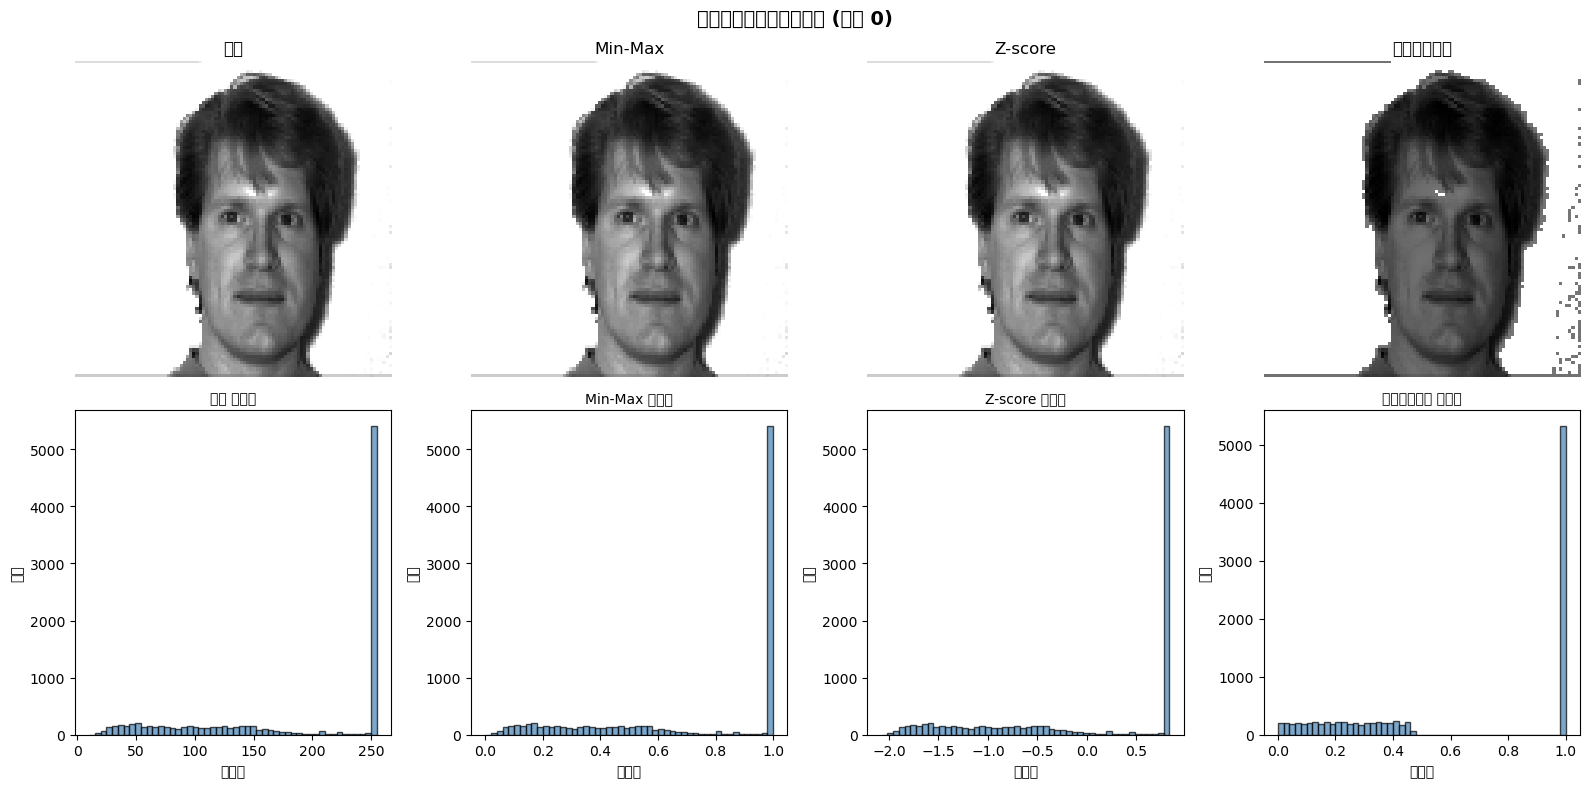

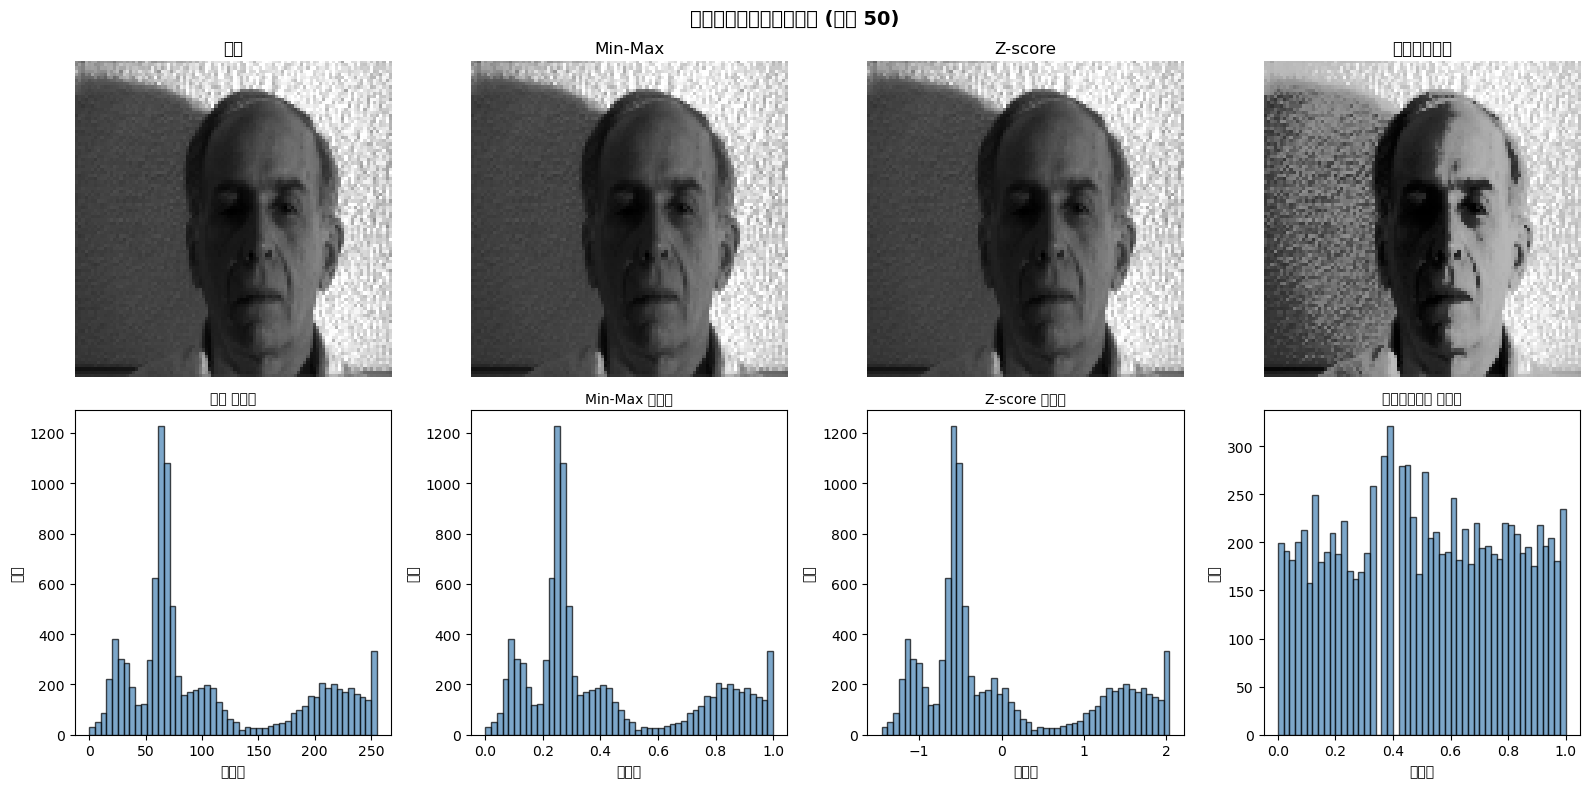

In [17]:
# 可视化不同归一化方法的效果
def plot_normalization_comparison(idx=0):
    """
    对比不同归一化方法的效果
    """
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # 第一行：图像
    methods = ['原始', 'Min-Max', 'Z-score', '直方图均衡化']
    imgs = [images_resized[idx], images_minmax[idx], images_zscore[idx], images_histeq[idx]]
    
    for i, (method, img) in enumerate(zip(methods, imgs)):
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(method, fontsize=12)
        axes[0, i].axis('off')
    
    # 第二行：直方图
    for i, (method, img) in enumerate(zip(methods, imgs)):
        axes[1, i].hist(img.flatten(), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
        axes[1, i].set_xlabel('像素值', fontsize=10)
        axes[1, i].set_ylabel('频次', fontsize=10)
        axes[1, i].set_title(f'{method} 直方图', fontsize=10)
    
    plt.suptitle(f'不同灰度归一化方法对比 (样本 {idx})', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# 展示几个样本的对比
plot_normalization_comparison(idx=0)
plot_normalization_comparison(idx=50)

In [19]:
# 选择最终使用的归一化方法（这里选择直方图均衡化，可以更好地增强对比度）
# 您也可以选择其他方法，根据实际效果调整

images_normalized = images_histeq.copy()
print(f"选择的归一化方法: 直方图均衡化")
print(f"归一化后的图像形状: {images_normalized.shape}")
print(f"数据范围: [{images_normalized.min():.3f}, {images_normalized.max():.3f}]")

选择的归一化方法: 直方图均衡化
归一化后的图像形状: (165, 100, 100)
数据范围: [0.000, 1.000]


## 5. 特征提取

### 5.1 全局特征 - PCA (主成分分析)

In [20]:
# 将图像展平为一维向量
n_samples = images_normalized.shape[0]
n_features = images_normalized.shape[1] * images_normalized.shape[2]

images_flat = images_normalized.reshape(n_samples, n_features)
print(f"展平后的数据形状: {images_flat.shape}")

# 标准化
scaler = StandardScaler()
images_scaled = scaler.fit_transform(images_flat)

# PCA降维
n_components = 50  # 保留50个主成分
pca = PCA(n_components=n_components)
pca_features = pca.fit_transform(images_scaled)

print(f"\nPCA特征形状: {pca_features.shape}")
print(f"累积方差解释率: {pca.explained_variance_ratio_.sum():.4f}")

展平后的数据形状: (165, 10000)

PCA特征形状: (165, 50)
累积方差解释率: 0.9277


C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\927733162.py:22: UserWarning: Glyph 20027 (\N{CJK UNIFIED IDEOGRAPH-4E3B}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\927733162.py:22: UserWarning: Glyph 25104 (\N{CJK UNIFIED IDEOGRAPH-6210}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\927733162.py:22: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\927733162.py:22: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\927733162.py:22: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\927733162.py:22: UserWarning: G

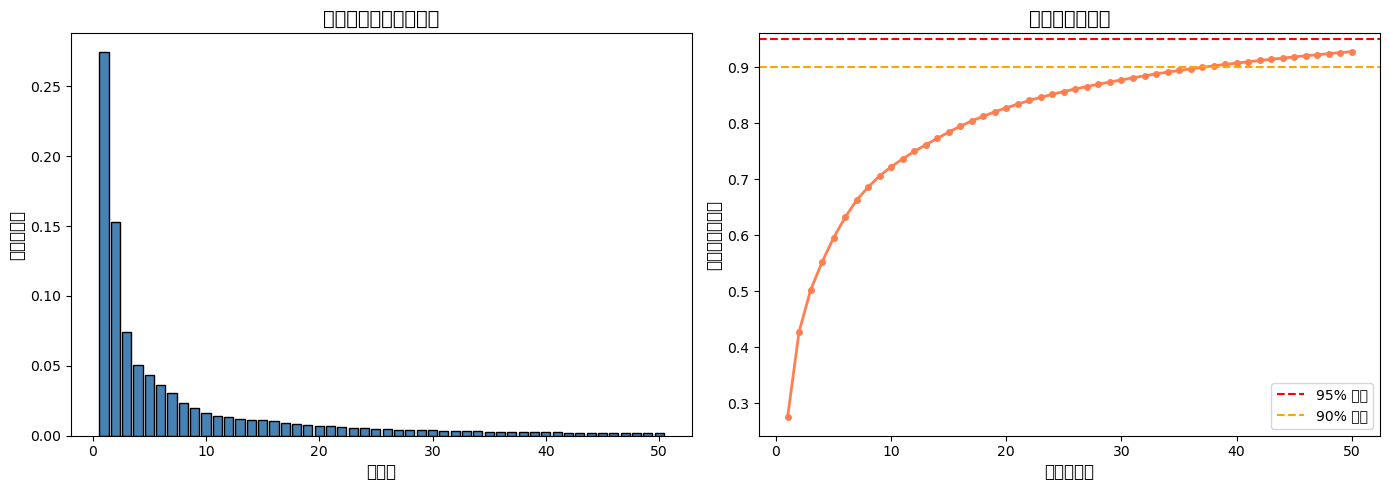

达到95%方差解释率所需的主成分数: 1


In [21]:
# 可视化PCA方差解释率
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 各主成分的方差解释率
axes[0].bar(range(1, n_components + 1), pca.explained_variance_ratio_, 
            color='steelblue', edgecolor='black')
axes[0].set_xlabel('主成分', fontsize=12)
axes[0].set_ylabel('方差解释率', fontsize=12)
axes[0].set_title('各主成分的方差解释率', fontsize=14, fontweight='bold')

# 累积方差解释率
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
axes[1].plot(range(1, n_components + 1), cumulative_variance, 
             marker='o', markersize=4, color='coral', linewidth=2)
axes[1].axhline(y=0.95, color='red', linestyle='--', label='95% 阈值')
axes[1].axhline(y=0.90, color='orange', linestyle='--', label='90% 阈值')
axes[1].set_xlabel('主成分数量', fontsize=12)
axes[1].set_ylabel('累积方差解释率', fontsize=12)
axes[1].set_title('累积方差解释率', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

# 找到达到95%方差解释率所需的主成分数
n_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"达到95%方差解释率所需的主成分数: {n_95}")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\3017316225.py:13: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\3017316225.py:13: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\3017316225.py:13: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\3017316225.py:13: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\3017316225.py:13: UserWarning: Glyph 33080 (\N{CJK UNIFIED IDEOGRAPH-8138}) missing from current font.
  plt.tight_layout()
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2106

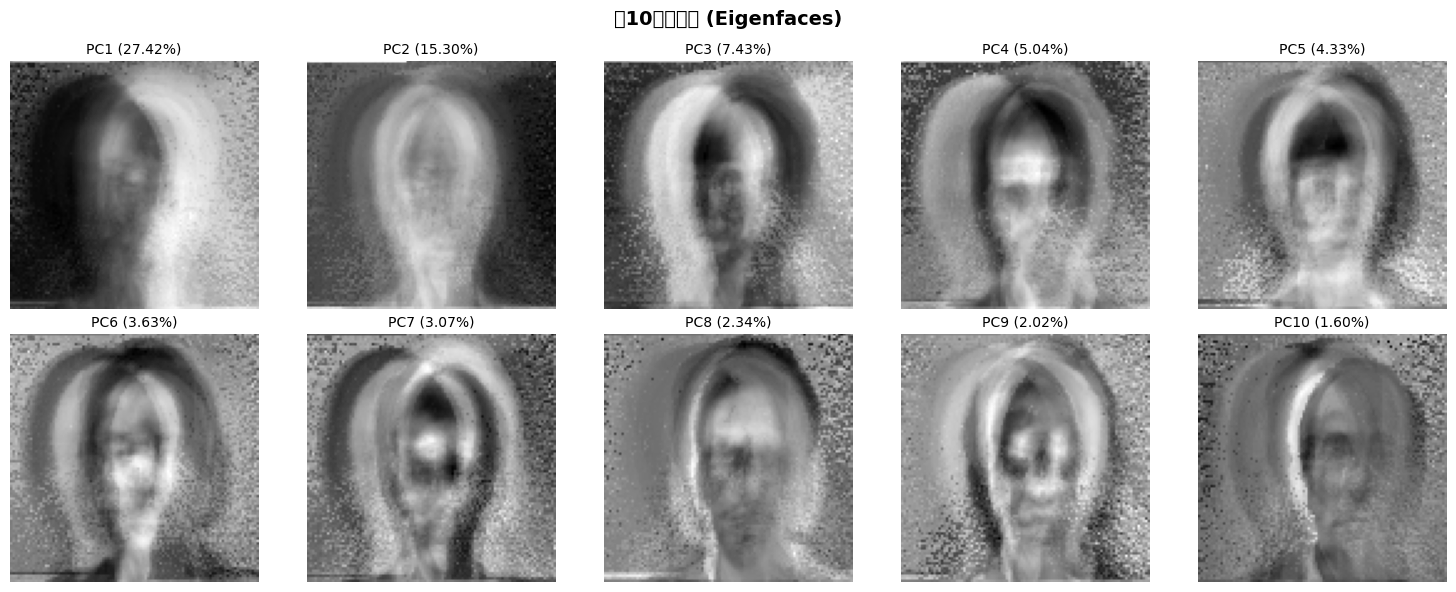

In [22]:
# 可视化特征脸 (Eigenfaces)
n_eigenfaces = 10
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flatten()):
    eigenface = pca.components_[i].reshape(TARGET_SIZE)
    ax.imshow(eigenface, cmap='gray')
    variance = pca.explained_variance_ratio_[i] * 100
    ax.set_title(f'PC{i+1} ({variance:.2f}%)', fontsize=10)
    ax.axis('off')

plt.suptitle('前10个特征脸 (Eigenfaces)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\773682099.py:33: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\773682099.py:33: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\773682099.py:33: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\773682099.py:33: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\773682099.py:33: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\773682099.py:33: UserWarning: G

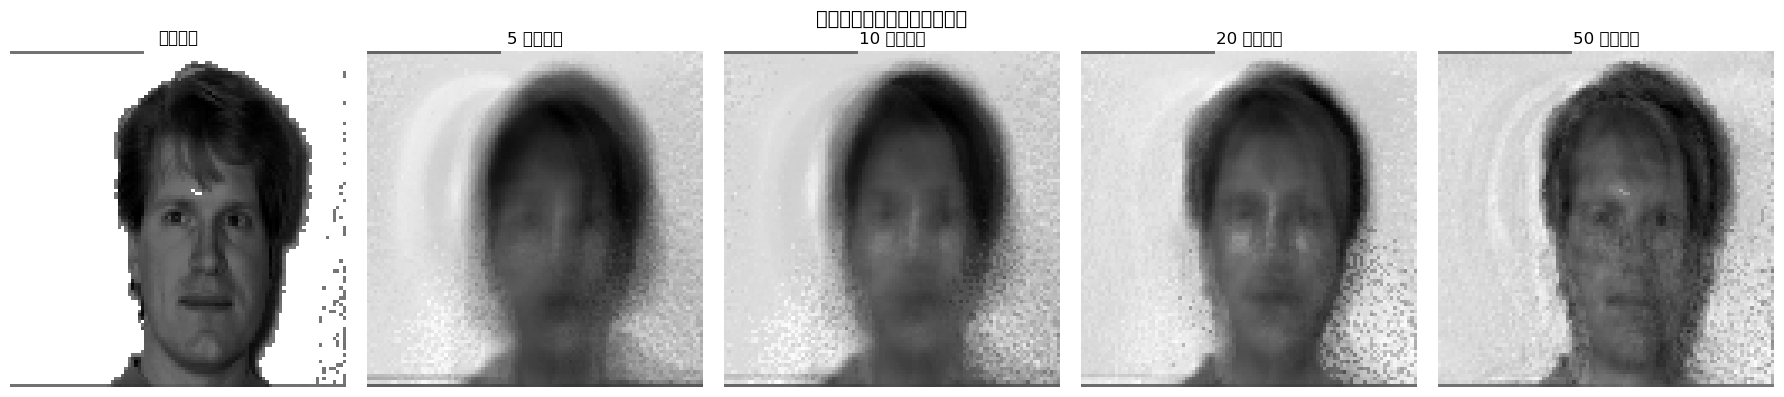

C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\773682099.py:33: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\773682099.py:33: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\773682099.py:33: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\773682099.py:33: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\773682099.py:33: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\773682099.py:33: UserWarning: G

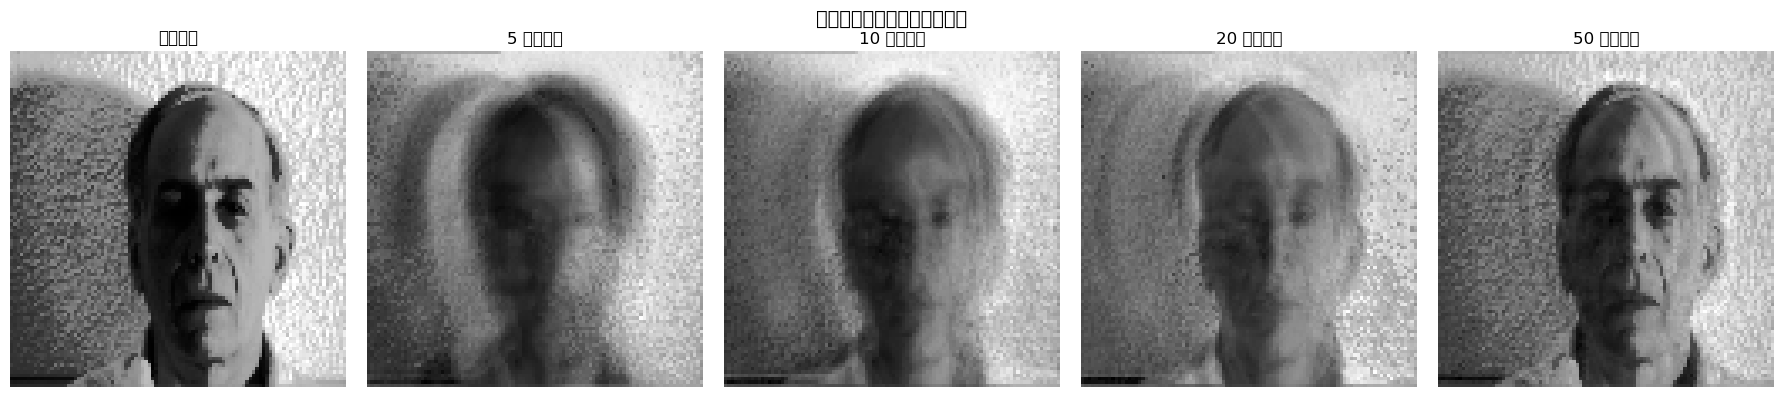

In [23]:
# 使用PCA重建图像
def reconstruct_image(original_flat, pca, scaler, n_components_list=[5, 10, 20, 50]):
    """
    使用不同数量的主成分重建图像
    """
    original_scaled = scaler.transform(original_flat.reshape(1, -1))
    original_img = original_flat.reshape(TARGET_SIZE)
    
    fig, axes = plt.subplots(1, len(n_components_list) + 1, figsize=(18, 4))
    
    # 原始图像
    axes[0].imshow(original_img, cmap='gray')
    axes[0].set_title('原始图像', fontsize=12)
    axes[0].axis('off')
    
    # 重建图像
    for i, n_comp in enumerate(n_components_list):
        # 投影到低维空间
        pca_temp = PCA(n_components=n_comp)
        pca_temp.fit(images_scaled)
        projected = pca_temp.transform(original_scaled)
        
        # 重建
        reconstructed = pca_temp.inverse_transform(projected)
        reconstructed = scaler.inverse_transform(reconstructed)
        reconstructed_img = reconstructed.reshape(TARGET_SIZE)
        
        axes[i + 1].imshow(reconstructed_img, cmap='gray')
        axes[i + 1].set_title(f'{n_comp} 个主成分', fontsize=12)
        axes[i + 1].axis('off')
    
    plt.suptitle('使用不同主成分数量重建图像', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# 展示重建效果
reconstruct_image(images_flat[0], pca, scaler)
reconstruct_image(images_flat[50], pca, scaler)

### 5.2 局部特征 - LBP (局部二值模式)

In [24]:
def extract_lbp_features(images, radius=1, n_points=8):
    """
    提取LBP特征
    """
    lbp_features = []
    lbp_images = []
    
    for img in images:
        # 转换为uint8格式
        img_uint8 = (img * 255).astype(np.uint8)
        
        # 计算LBP
        lbp = local_binary_pattern(img_uint8, n_points, radius, method='uniform')
        lbp_images.append(lbp)
        
        # 计算LBP直方图作为特征
        n_bins = int(lbp.max() + 1)
        hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins), density=True)
        lbp_features.append(hist)
    
    return np.array(lbp_features), lbp_images

# 提取LBP特征
print("正在提取LBP特征...")
lbp_features, lbp_images = extract_lbp_features(images_normalized)
print(f"LBP特征形状: {lbp_features.shape}")

正在提取LBP特征...
LBP特征形状: (165, 10)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\1018655084.py:18: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\1018655084.py:18: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\1018655084.py:18: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\1018655084.py:18: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\1018655084.py:18: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\1018655084.py:18: UserWarn

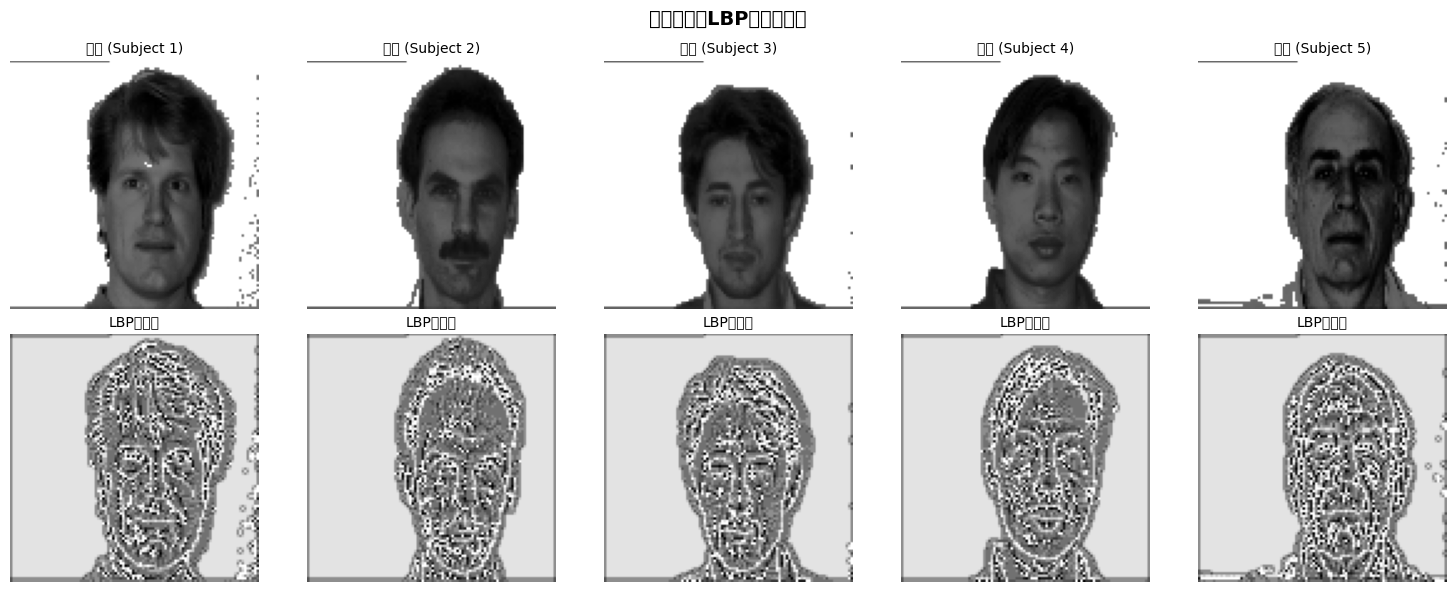

In [25]:
# 可视化LBP特征图
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

sample_indices = [0, 11, 22, 33, 44]

for i, idx in enumerate(sample_indices):
    # 原始图像
    axes[0, i].imshow(images_normalized[idx], cmap='gray')
    axes[0, i].set_title(f'原始 (Subject {labels[idx]})', fontsize=10)
    axes[0, i].axis('off')
    
    # LBP图像
    axes[1, i].imshow(lbp_images[idx], cmap='gray')
    axes[1, i].set_title('LBP特征图', fontsize=10)
    axes[1, i].axis('off')

plt.suptitle('原始图像与LBP特征图对比', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\840383285.py:24: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\840383285.py:24: UserWarning: Glyph 24335 (\N{CJK UNIFIED IDEOGRAPH-5F0F}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\840383285.py:24: UserWarning: Glyph 24402 (\N{CJK UNIFIED IDEOGRAPH-5F52}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\840383285.py:24: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\840383285.py:24: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\840383285.py:24: UserWarning: G

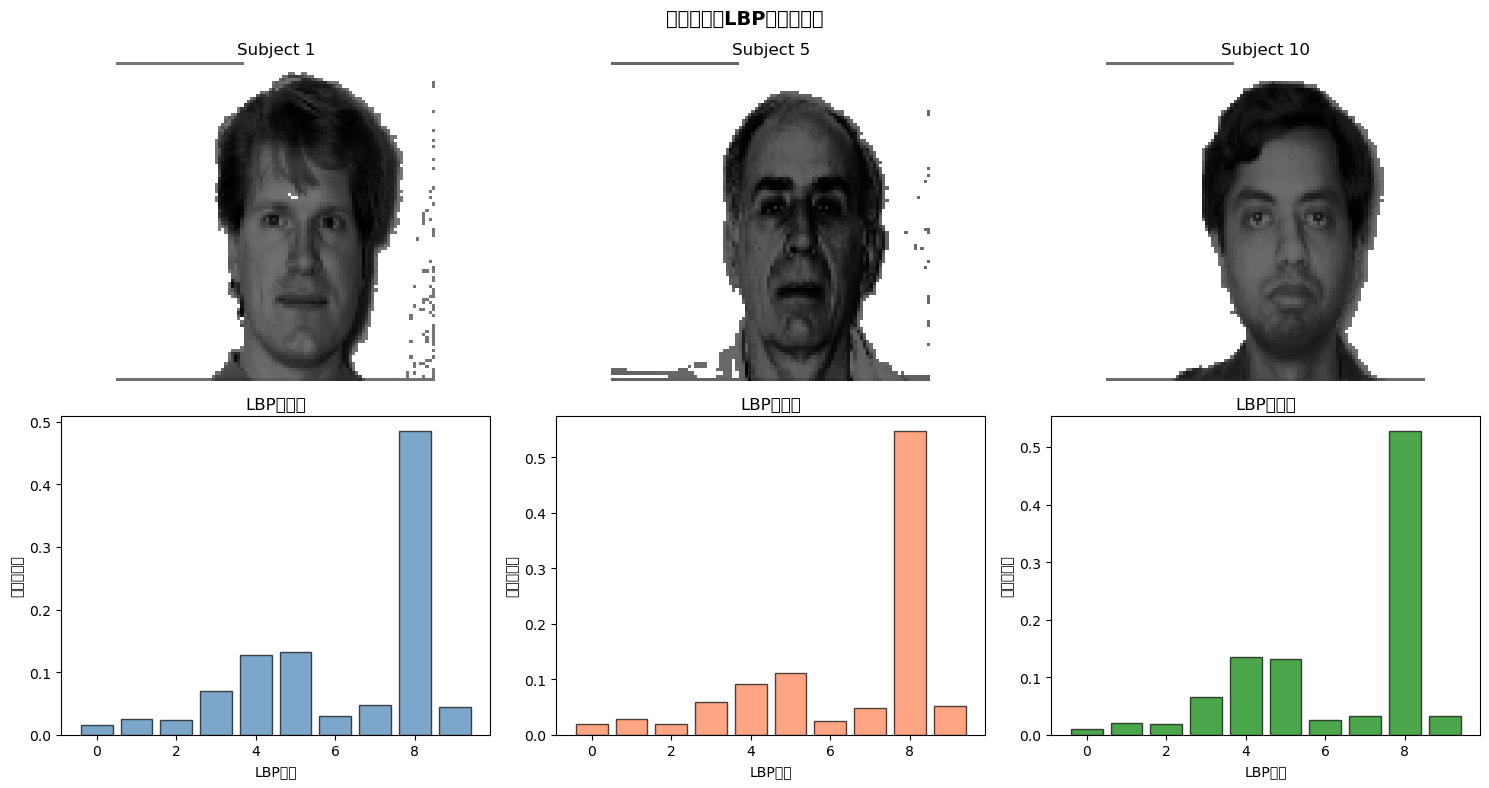

In [26]:
# 可视化LBP直方图
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# 比较不同被试的LBP直方图
sample_subjects = [1, 5, 10]
colors = ['steelblue', 'coral', 'green']

for i, subj in enumerate(sample_subjects):
    idx = labels.index(subj)
    
    # 图像
    axes[0, i].imshow(images_normalized[idx], cmap='gray')
    axes[0, i].set_title(f'Subject {subj}', fontsize=12)
    axes[0, i].axis('off')
    
    # LBP直方图
    axes[1, i].bar(range(len(lbp_features[idx])), lbp_features[idx], 
                   color=colors[i], edgecolor='black', alpha=0.7)
    axes[1, i].set_xlabel('LBP模式', fontsize=10)
    axes[1, i].set_ylabel('归一化频次', fontsize=10)
    axes[1, i].set_title(f'LBP直方图', fontsize=12)

plt.suptitle('不同被试的LBP特征直方图', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 5.3 局部特征 - HOG (方向梯度直方图)

In [27]:
def extract_hog_features(images, orientations=9, pixels_per_cell=(8, 8), 
                         cells_per_block=(2, 2), visualize=False):
    """
    提取HOG特征
    """
    hog_features = []
    hog_images = [] if visualize else None
    
    for img in images:
        # 转换为uint8格式
        img_uint8 = (img * 255).astype(np.uint8)
        
        if visualize:
            features, hog_img = hog(img_uint8, orientations=orientations,
                                     pixels_per_cell=pixels_per_cell,
                                     cells_per_block=cells_per_block,
                                     visualize=True)
            hog_images.append(hog_img)
        else:
            features = hog(img_uint8, orientations=orientations,
                          pixels_per_cell=pixels_per_cell,
                          cells_per_block=cells_per_block,
                          visualize=False)
        
        hog_features.append(features)
    
    return np.array(hog_features), hog_images

# 提取HOG特征
print("正在提取HOG特征...")
hog_features, hog_images = extract_hog_features(images_normalized, visualize=True)
print(f"HOG特征形状: {hog_features.shape}")

正在提取HOG特征...
HOG特征形状: (165, 4356)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\1193898506.py:19: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\1193898506.py:19: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\1193898506.py:19: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\1193898506.py:19: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\1193898506.py:19: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\1193898506.py:19: UserWarn

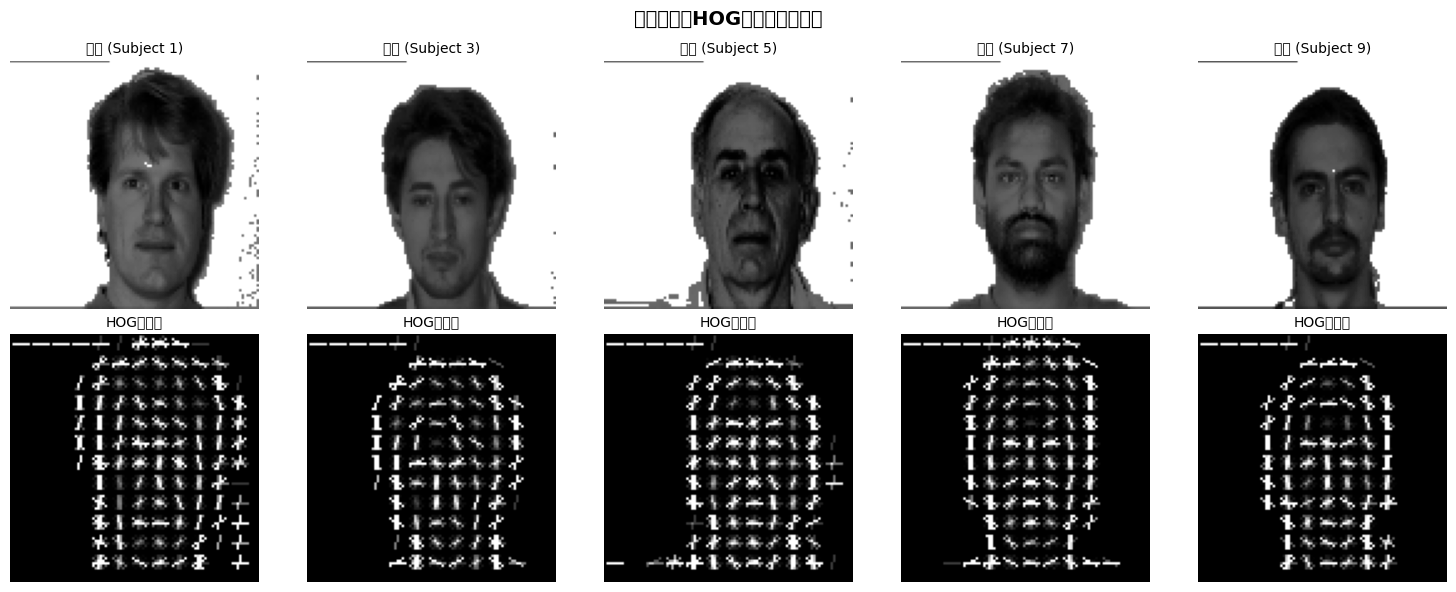

In [28]:
# 可视化HOG特征
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

sample_indices = [0, 22, 44, 66, 88]

for i, idx in enumerate(sample_indices):
    # 原始图像
    axes[0, i].imshow(images_normalized[idx], cmap='gray')
    axes[0, i].set_title(f'原始 (Subject {labels[idx]})', fontsize=10)
    axes[0, i].axis('off')
    
    # HOG可视化
    hog_img_rescaled = exposure.rescale_intensity(hog_images[idx], in_range=(0, 10))
    axes[1, i].imshow(hog_img_rescaled, cmap='gray')
    axes[1, i].set_title('HOG特征图', fontsize=10)
    axes[1, i].axis('off')

plt.suptitle('原始图像与HOG特征可视化对比', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\832402106.py:29: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\832402106.py:29: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\832402106.py:29: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\832402106.py:29: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\832402106.py:29: UserWarning: Glyph 21487 (\N{CJK UNIFIED IDEOGRAPH-53EF}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\832402106.py:29: UserWarning: G

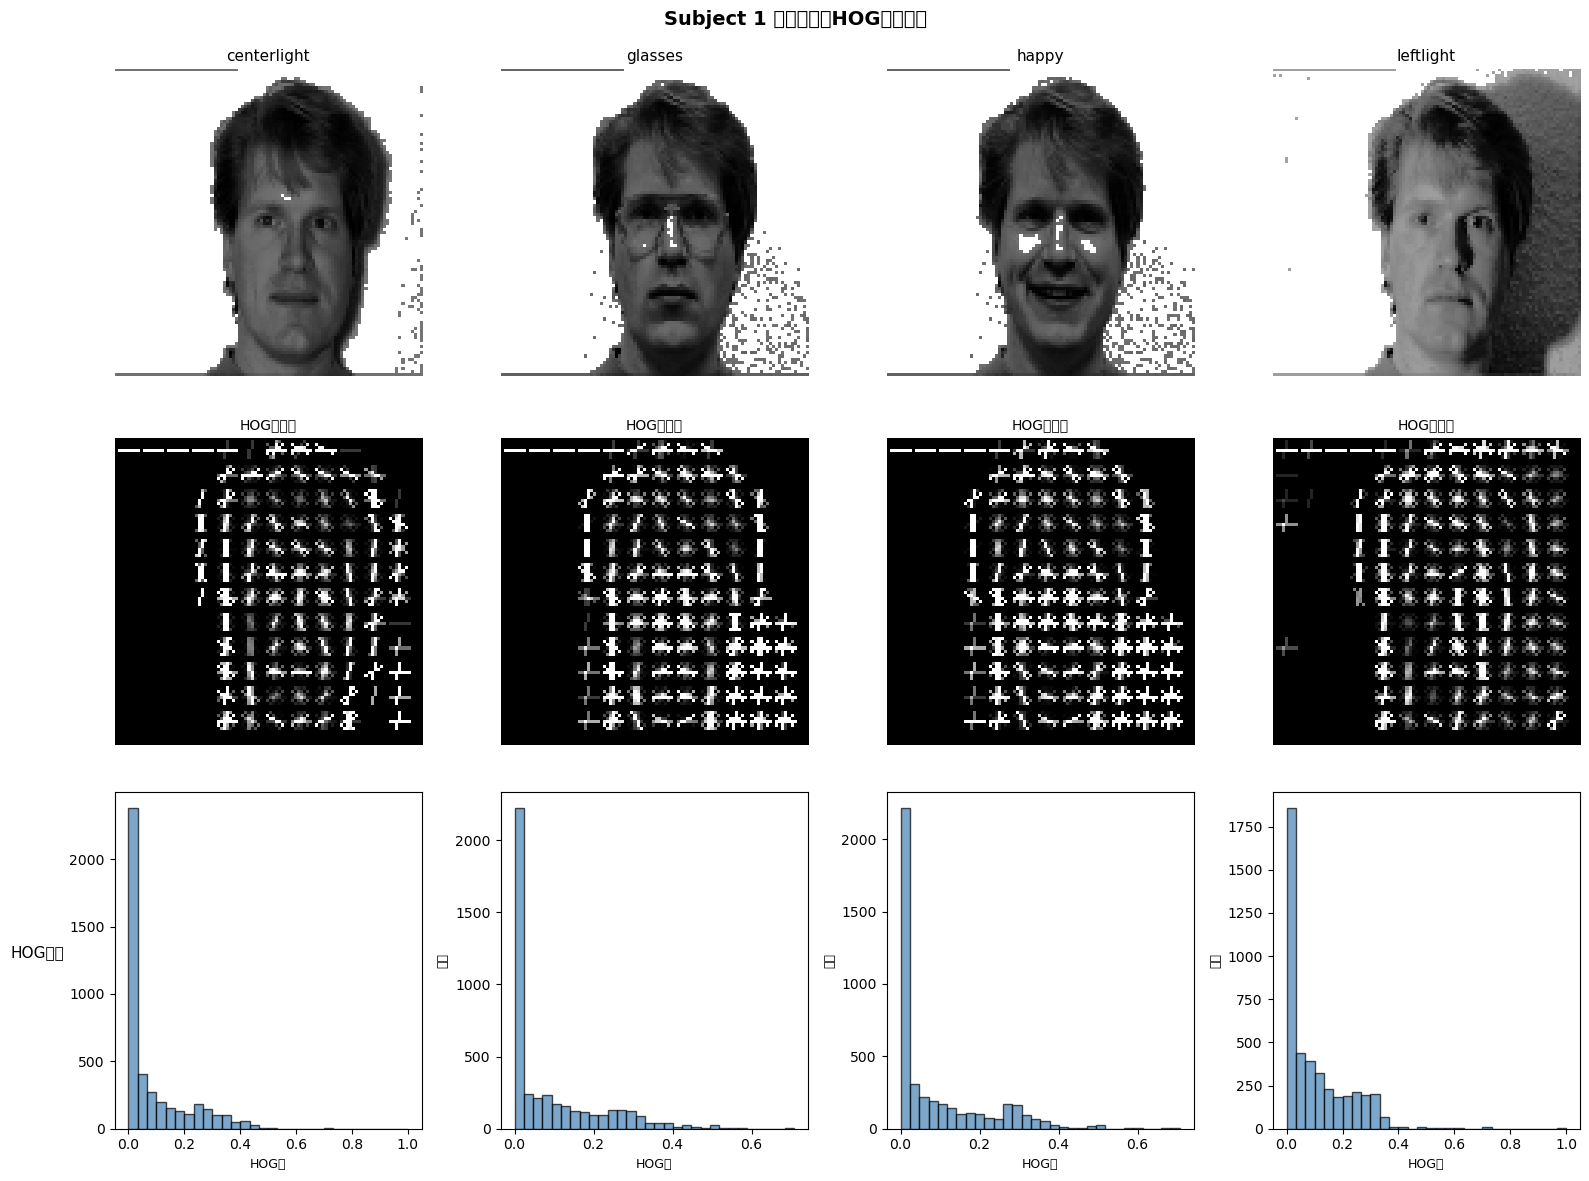

In [29]:
# 对比同一被试不同表情的HOG特征
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

# 选择被试1的4个表情
subject1_indices = [i for i, l in enumerate(labels) if l == 1][:4]

for i, idx in enumerate(subject1_indices):
    # 原始图像
    axes[0, i].imshow(images_normalized[idx], cmap='gray')
    axes[0, i].set_title(f'{expressions[idx]}', fontsize=11)
    axes[0, i].axis('off')
    
    # HOG可视化
    hog_img_rescaled = exposure.rescale_intensity(hog_images[idx], in_range=(0, 10))
    axes[1, i].imshow(hog_img_rescaled, cmap='gray')
    axes[1, i].set_title('HOG特征图', fontsize=10)
    axes[1, i].axis('off')
    
    # HOG特征分布
    axes[2, i].hist(hog_features[idx], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    axes[2, i].set_xlabel('HOG值', fontsize=9)
    axes[2, i].set_ylabel('频次', fontsize=9)

axes[0, 0].set_ylabel('原始图像', fontsize=11, rotation=0, ha='right')
axes[1, 0].set_ylabel('HOG可视化', fontsize=11, rotation=0, ha='right')
axes[2, 0].set_ylabel('HOG分布', fontsize=11, rotation=0, ha='right')

plt.suptitle('Subject 1 不同表情的HOG特征对比', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. 特征融合与可视化

In [30]:
# 特征融合：将PCA、LBP、HOG特征组合
print("特征维度汇总:")
print(f"  PCA特征: {pca_features.shape[1]} 维")
print(f"  LBP特征: {lbp_features.shape[1]} 维")
print(f"  HOG特征: {hog_features.shape[1]} 维")

# 标准化各特征
scaler_pca = StandardScaler()
scaler_lbp = StandardScaler()
scaler_hog = StandardScaler()

pca_scaled = scaler_pca.fit_transform(pca_features)
lbp_scaled = scaler_lbp.fit_transform(lbp_features)
hog_scaled = scaler_hog.fit_transform(hog_features)

# 融合特征
combined_features = np.hstack([pca_scaled, lbp_scaled, hog_scaled])
print(f"\n融合后的特征维度: {combined_features.shape[1]} 维")

特征维度汇总:
  PCA特征: 50 维
  LBP特征: 10 维
  HOG特征: 4356 维

融合后的特征维度: 4416 维


正在进行t-SNE降维可视化...


d:\Anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系统找不到指定的文件。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\Anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "d:\Anaconda\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Anaconda\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "d:\Anaconda\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
C:\Users\

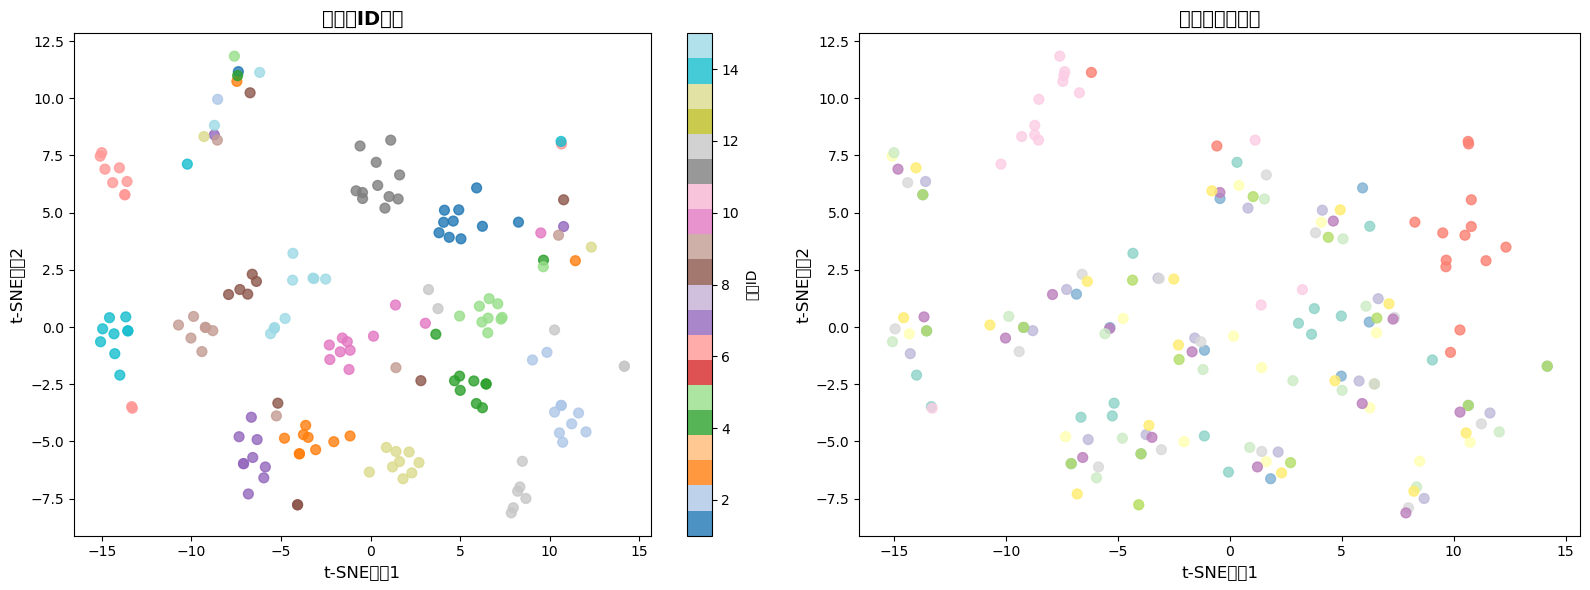

t-SNE可视化完成！


In [31]:
# 使用t-SNE可视化特征分布
from sklearn.manifold import TSNE

print("正在进行t-SNE降维可视化...")

# 对融合特征进行t-SNE降维
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_2d = tsne.fit_transform(combined_features)

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 按被试ID着色
scatter1 = axes[0].scatter(features_2d[:, 0], features_2d[:, 1], 
                           c=labels, cmap='tab20', s=50, alpha=0.8)
axes[0].set_xlabel('t-SNE维度1', fontsize=12)
axes[0].set_ylabel('t-SNE维度2', fontsize=12)
axes[0].set_title('按被试ID着色', fontsize=14, fontweight='bold')
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('被试ID')

# 按表情类型着色
expr_to_num = {e: i for i, e in enumerate(EXPRESSIONS)}
expr_nums = [expr_to_num[e] for e in expressions]

scatter2 = axes[1].scatter(features_2d[:, 0], features_2d[:, 1], 
                           c=expr_nums, cmap='Set3', s=50, alpha=0.8)
axes[1].set_xlabel('t-SNE维度1', fontsize=12)
axes[1].set_ylabel('t-SNE维度2', fontsize=12)
axes[1].set_title('按表情类型着色', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("t-SNE可视化完成！")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\3406371726.py:18: UserWarning: Glyph 32500 (\N{CJK UNIFIED IDEOGRAPH-7EF4}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\3406371726.py:18: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\3406371726.py:18: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\3406371726.py:18: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\3406371726.py:18: UserWarning: Glyph 21487 (\N{CJK UNIFIED IDEOGRAPH-53EF}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_323544\3406371726.py:18: UserWarn

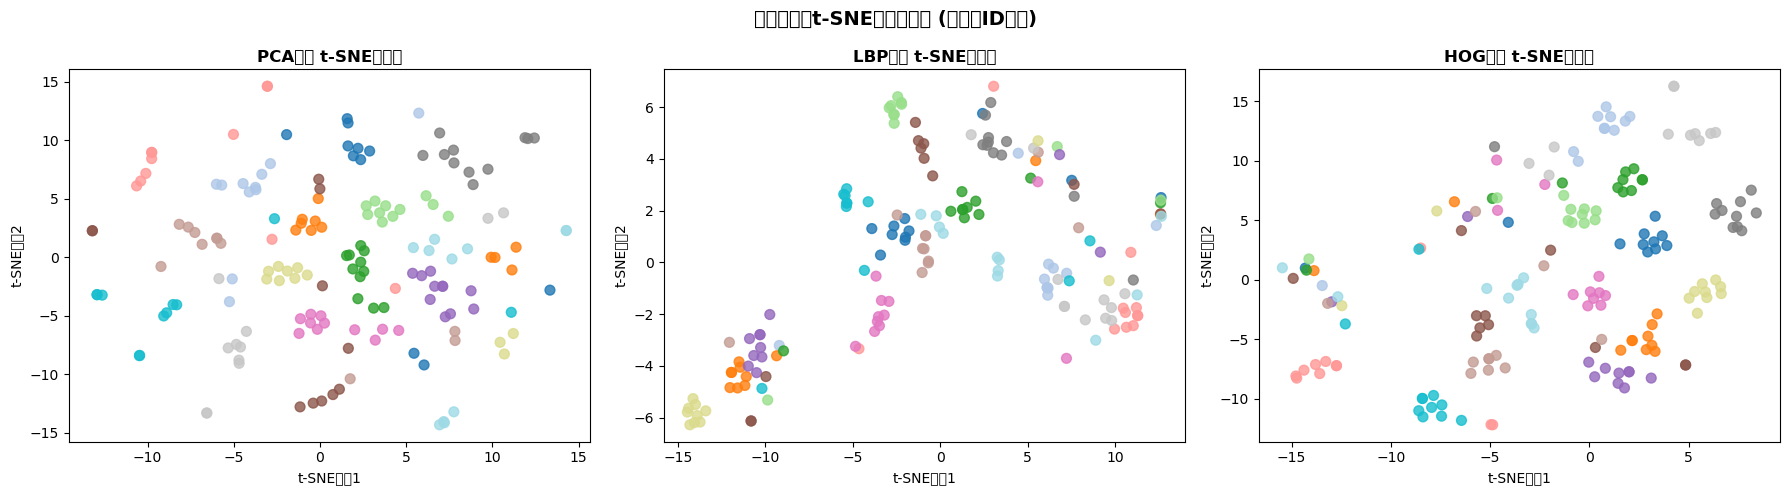

In [32]:
# 分别可视化各类特征的t-SNE
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

features_list = [pca_scaled, lbp_scaled, hog_scaled]
titles = ['PCA特征', 'LBP特征', 'HOG特征']

for i, (feat, title) in enumerate(zip(features_list, titles)):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    feat_2d = tsne.fit_transform(feat)
    
    scatter = axes[i].scatter(feat_2d[:, 0], feat_2d[:, 1], 
                              c=labels, cmap='tab20', s=50, alpha=0.8)
    axes[i].set_xlabel('t-SNE维度1', fontsize=10)
    axes[i].set_ylabel('t-SNE维度2', fontsize=10)
    axes[i].set_title(f'{title} t-SNE可视化', fontsize=12, fontweight='bold')

plt.suptitle('不同特征的t-SNE可视化对比 (按被试ID着色)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. 数据保存

In [33]:
# 保存预处理后的数据和特征
import pickle

# 创建保存目录
output_dir = "./preprocessed_data"
os.makedirs(output_dir, exist_ok=True)

# 保存数据
data_dict = {
    'images_normalized': images_normalized,
    'labels': np.array(labels),
    'expressions': expressions,
    'filenames': filenames,
    'pca_features': pca_features,
    'lbp_features': lbp_features,
    'hog_features': hog_features,
    'combined_features': combined_features,
    'target_size': TARGET_SIZE,
    'expression_list': EXPRESSIONS
}

# 保存为numpy格式
np.savez(os.path.join(output_dir, 'yale_preprocessed.npz'),
         images=images_normalized,
         labels=np.array(labels),
         pca_features=pca_features,
         lbp_features=lbp_features,
         hog_features=hog_features,
         combined_features=combined_features)

# 保存完整数据（包括字符串）
with open(os.path.join(output_dir, 'yale_preprocessed_full.pkl'), 'wb') as f:
    pickle.dump(data_dict, f)

# 保存预处理器
preprocessors = {
    'pca': pca,
    'scaler': scaler,
    'scaler_pca': scaler_pca,
    'scaler_lbp': scaler_lbp,
    'scaler_hog': scaler_hog
}

with open(os.path.join(output_dir, 'preprocessors.pkl'), 'wb') as f:
    pickle.dump(preprocessors, f)

print(f"数据已保存到 {output_dir} 目录")
print(f"保存的文件:")
for f in os.listdir(output_dir):
    filepath = os.path.join(output_dir, f)
    size = os.path.getsize(filepath) / 1024  # KB
    print(f"  - {f}: {size:.2f} KB")

数据已保存到 ./preprocessed_data 目录
保存的文件:
  - preprocessors.pkl: 2332.21 KB
  - yale_preprocessed.npz: 17800.24 KB
  - yale_preprocessed_full.pkl: 17804.32 KB


## 8. 数据摘要与统计

In [34]:
# 打印完整的数据摘要
print("=" * 60)
print("Yale人脸数据集 - 预处理与特征工程摘要")
print("=" * 60)

print("\n【数据集基本信息】")
print(f"  总图像数量: {len(images)}")
print(f"  被试数量: {len(set(labels))} (ID: 1-15)")
print(f"  每个被试的图像数: {len(images) // len(set(labels))}")
print(f"  表情/状态类别: {len(EXPRESSIONS)} 种")
print(f"  类别列表: {EXPRESSIONS}")

print("\n【图像预处理】")
print(f"  目标尺寸: {TARGET_SIZE[0]} x {TARGET_SIZE[1]}")
print(f"  归一化方法: 直方图均衡化")
print(f"  像素值范围: [0.0, 1.0]")

print("\n【特征提取】")
print(f"  1. PCA特征: {pca_features.shape[1]} 维")
print(f"     - 累积方差解释率: {pca.explained_variance_ratio_.sum()*100:.2f}%")
print(f"  2. LBP特征: {lbp_features.shape[1]} 维")
print(f"     - 参数: radius=1, n_points=8, method='uniform'")
print(f"  3. HOG特征: {hog_features.shape[1]} 维")
print(f"     - 参数: orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2)")
print(f"  4. 融合特征: {combined_features.shape[1]} 维")

print("\n【输出文件】")
print(f"  - yale_preprocessed.npz: 数值数据")
print(f"  - yale_preprocessed_full.pkl: 完整数据（含字符串）")
print(f"  - preprocessors.pkl: 预处理器模型")

print("\n" + "=" * 60)
print("预处理与特征工程完成！")
print("=" * 60)

Yale人脸数据集 - 预处理与特征工程摘要

【数据集基本信息】
  总图像数量: 165
  被试数量: 15 (ID: 1-15)
  每个被试的图像数: 11
  表情/状态类别: 11 种
  类别列表: ['centerlight', 'glasses', 'happy', 'leftlight', 'noglasses', 'normal', 'rightlight', 'sad', 'sleepy', 'surprised', 'wink']

【图像预处理】
  目标尺寸: 100 x 100
  归一化方法: 直方图均衡化
  像素值范围: [0.0, 1.0]

【特征提取】
  1. PCA特征: 50 维
     - 累积方差解释率: 92.77%
  2. LBP特征: 10 维
     - 参数: radius=1, n_points=8, method='uniform'
  3. HOG特征: 4356 维
     - 参数: orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2)
  4. 融合特征: 4416 维

【输出文件】
  - yale_preprocessed.npz: 数值数据
  - yale_preprocessed_full.pkl: 完整数据（含字符串）
  - preprocessors.pkl: 预处理器模型

预处理与特征工程完成！


---

## 下一步

预处理后的数据和提取的特征已保存，可用于：

1. **人脸识别模型训练**
   - 使用 `combined_features` 或单独的特征训练分类器
   - 推荐算法：SVM、KNN、Random Forest、神经网络

2. **拒识系统构建**
   - 设置识别阈值
   - 使用距离度量判断是否为已知用户
   - 可考虑使用One-Class SVM或其他异常检测方法

3. **进一步优化**
   - 尝试不同的特征组合
   - 调整PCA主成分数量
   - 使用深度学习提取更高级的特征